In [3]:
import os
import os.path as ospath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_ring_data_df(dirname, filename):
    file = ospath.join(dirname, filename)

    try: 
        df = pd.read_pickle(file)
    except FileNotFoundError:
        print("No ring_data_filter.pkl file was found.")
        return None
    else: 
        return df

In [5]:
path = r'W:\users\reinhardt\z.software\Git\spor-PAINT\dev_sr\spor-paint\FtsZ\FtsZ_picks_all'
df = load_ring_data_df(path, "ring_data_filter.pkl")


print(df.keys())
"""
Index(['fov_id', 'cell_type', 'filename', 'group', 'residual', 'radius',
       'angle_between_ring_and_coverslip', 'Sigma', 'n_events', 'mean_bright',
       'mean_dark', 'fit_bright', 'fit_dark', 'filter_passed'],
      dtype='object')
"""

Index(['fov_id', 'cell_type', 'filename', 'group', 'residual', 'radius',
       'angle_between_ring_and_coverslip', 'Sigma', 'n_events', 'mean_bright',
       'mean_dark', 'fit_bright', 'fit_dark', 'filter_passed'],
      dtype='object')


"\nIndex(['fov_id', 'cell_type', 'filename', 'group', 'residual', 'radius',\n       'angle_between_ring_and_coverslip', 'Sigma', 'n_events', 'mean_bright',\n       'mean_dark', 'fit_bright', 'fit_dark', 'filter_passed'],\n      dtype='object')\n"

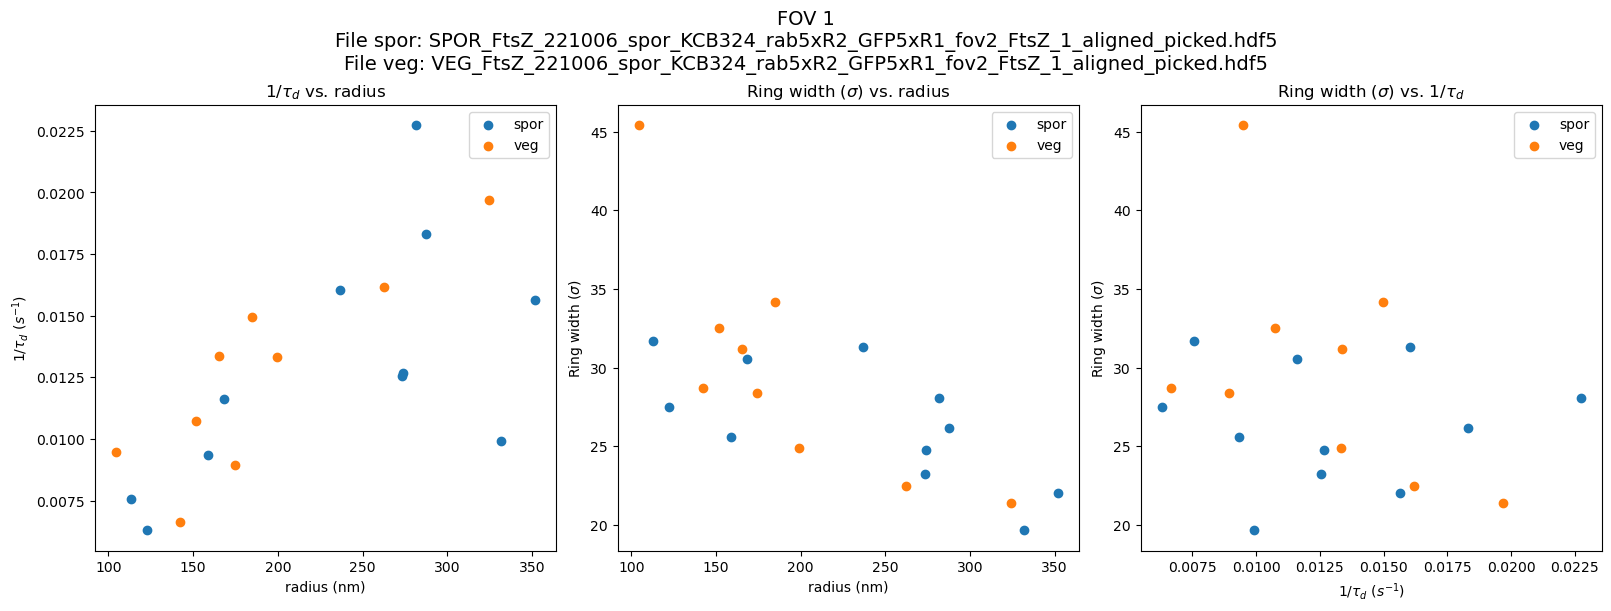

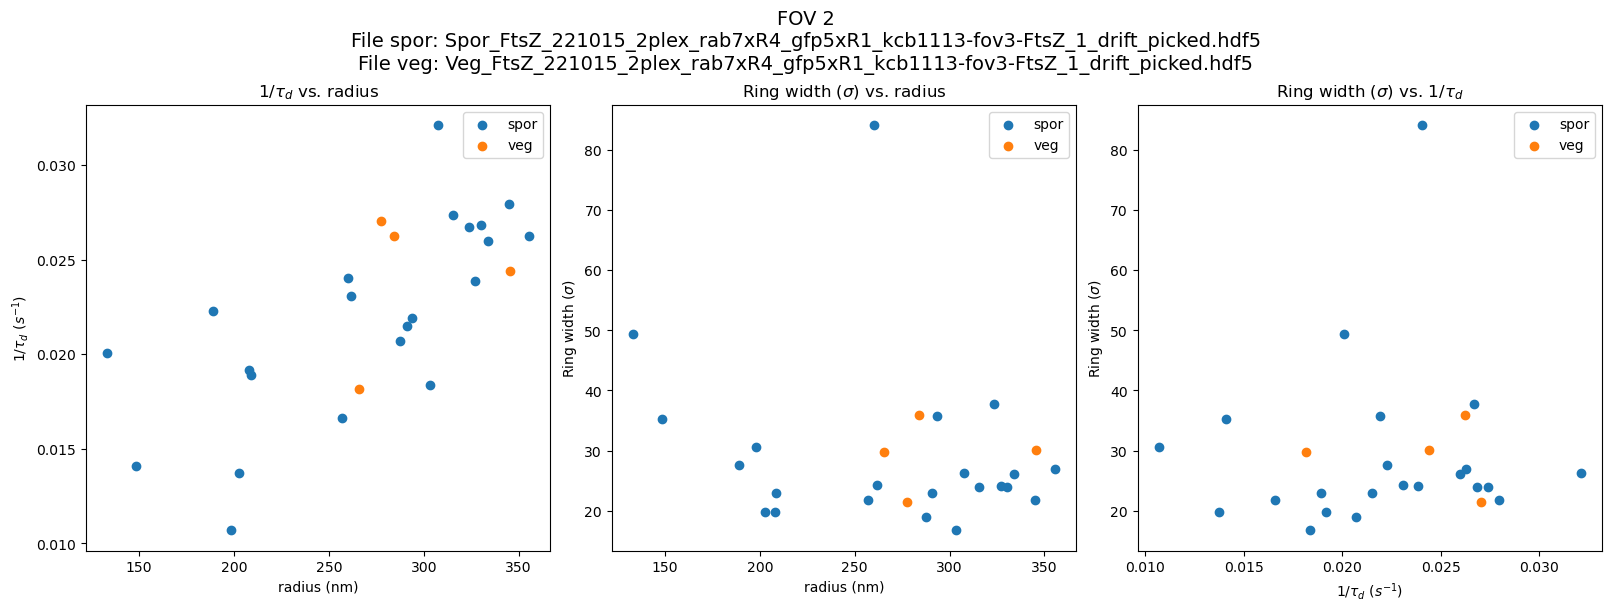

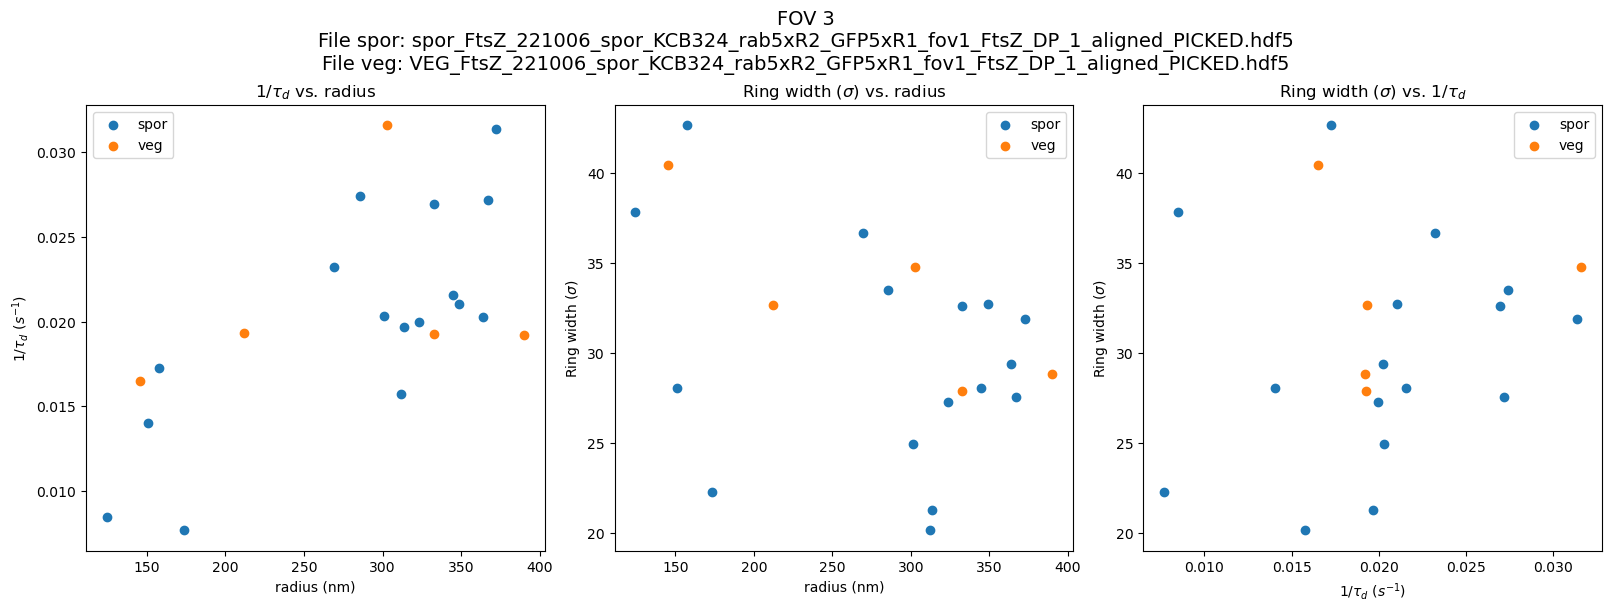

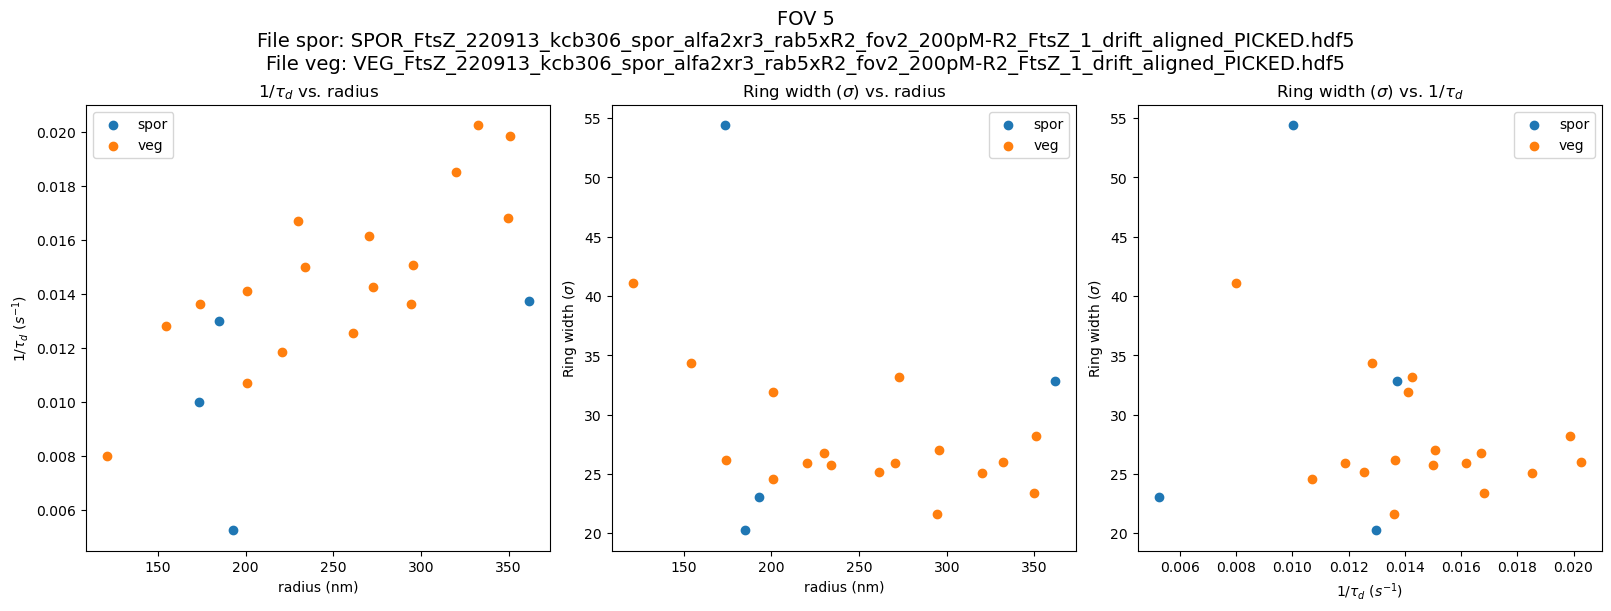

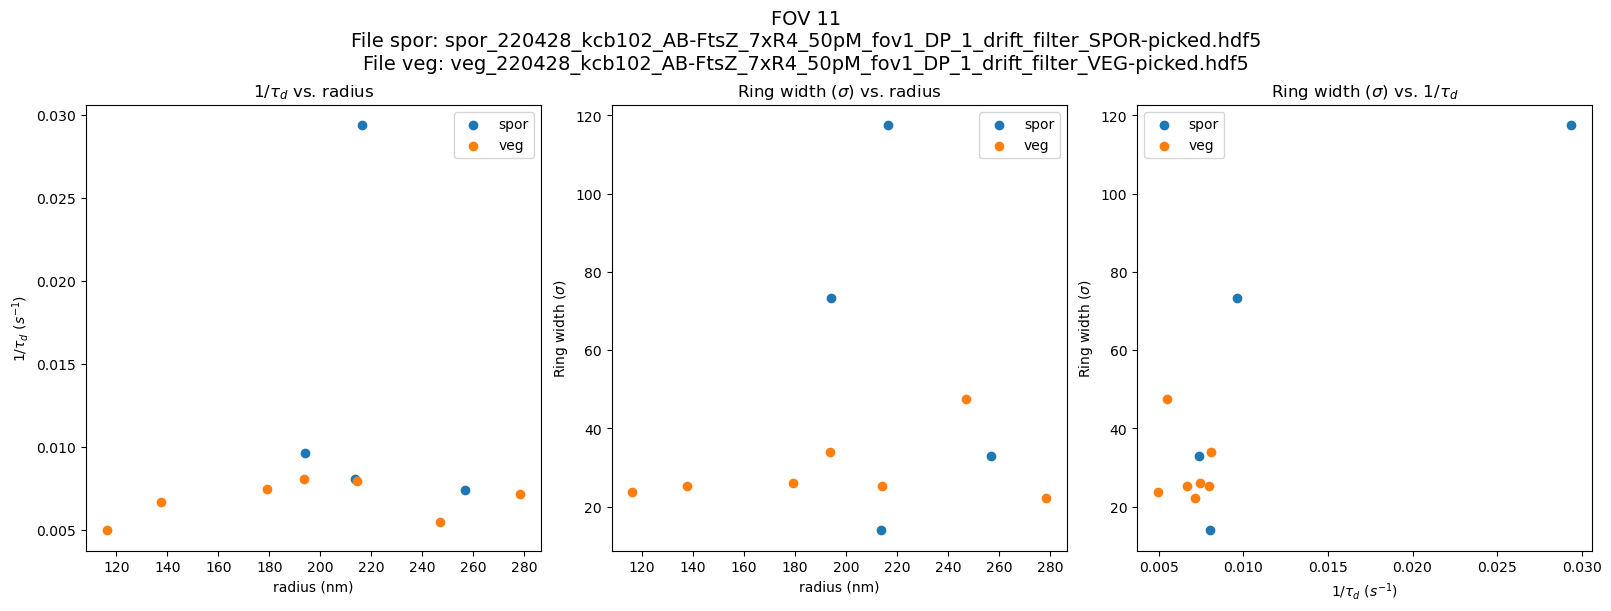

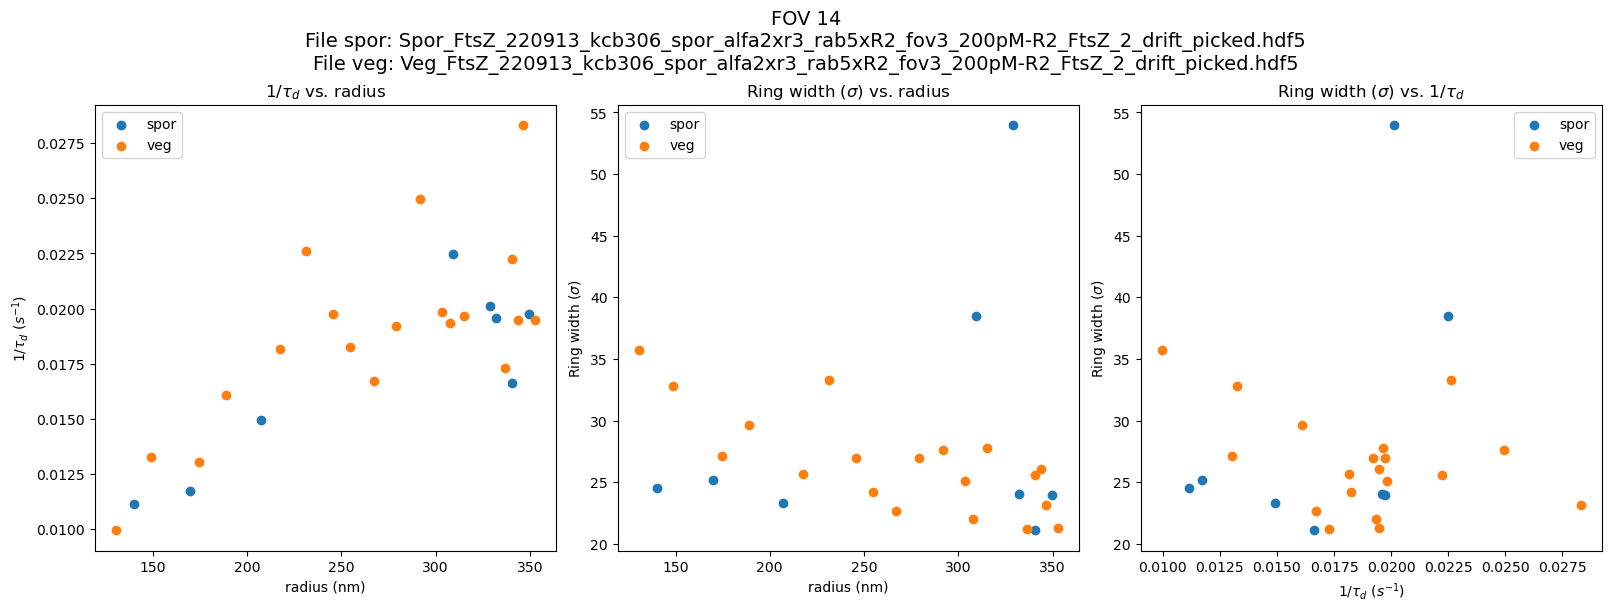

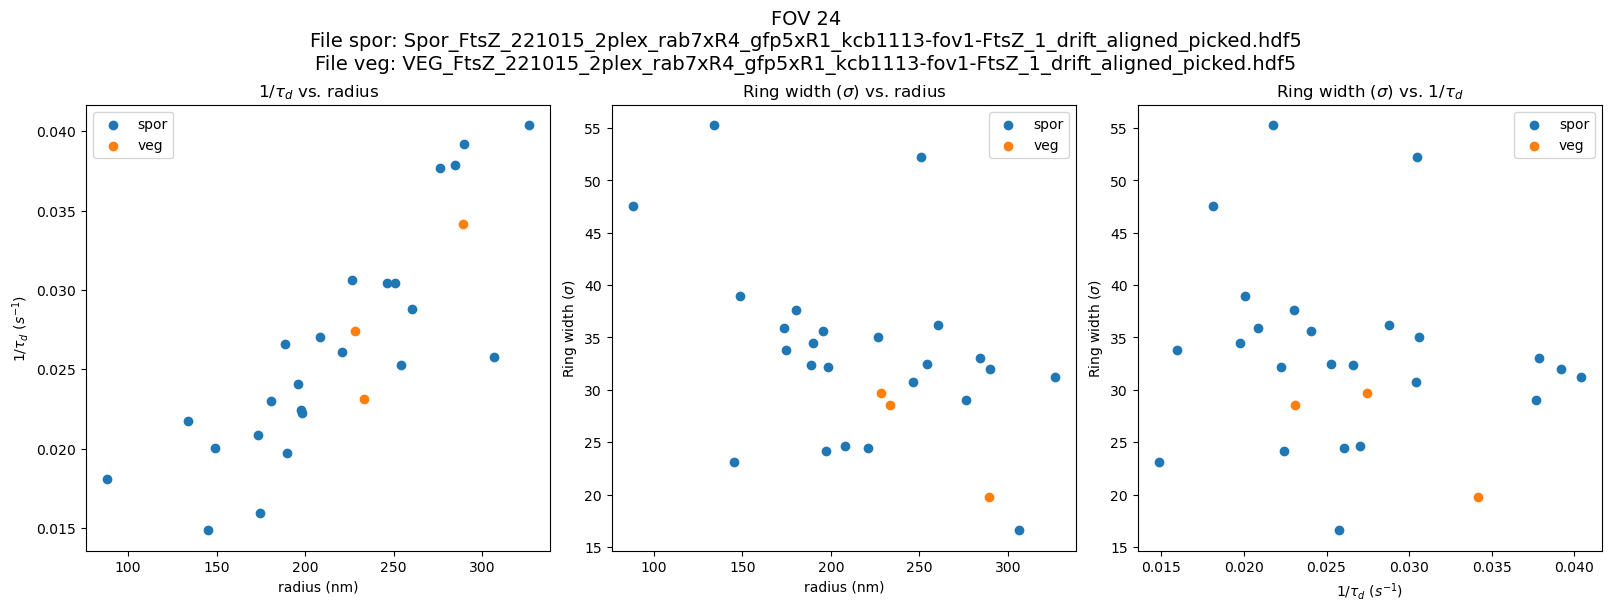

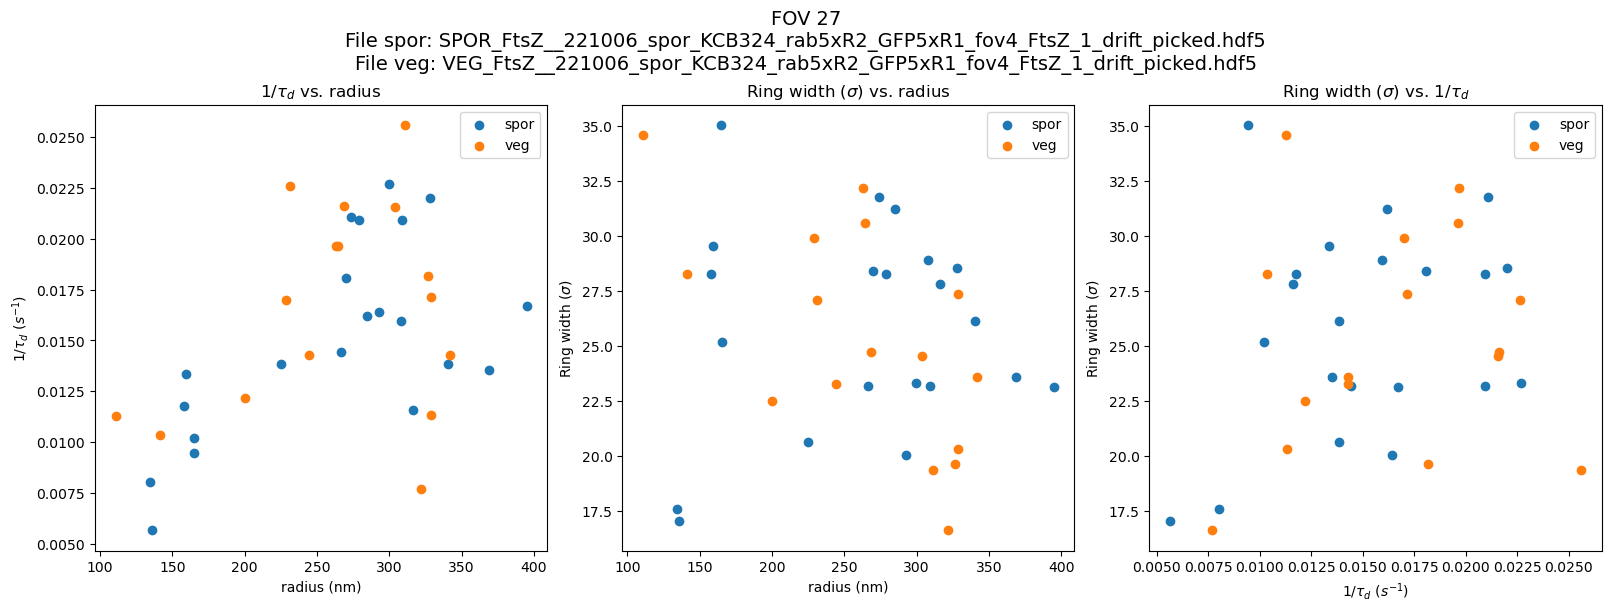

In [50]:
fov_id_max = df['fov_id'].max()

for fov_id in range(fov_id_max):
    df_fov_id_spor = df[(df['fov_id']==fov_id) & (df['cell_type']=='spor') & (df['filter_passed']=='Yes')]
    df_fov_id_veg = df[(df['fov_id']==fov_id) & (df['cell_type']=='veg') & (df['filter_passed']=='Yes')]
    
    if (len(df_fov_id_spor)==0) or (len(df_fov_id_veg)==0):
        continue

        
    fig = plt.figure(figsize=(16, 6), constrained_layout=True) 
    gs = fig.add_gridspec(1,3)

    fig.suptitle(("FOV {}\n"
                  "File spor: {}\n"
                  "File veg: {}").format(fov_id,df_fov_id_spor['filename'].iloc[0], df_fov_id_veg['filename'].iloc[0]), 
                 fontsize=14, 
                 ha="center")
    
    
    # plot 1/dark time vs. radius
    ax1 = fig.add_subplot(gs[0, 0])  
    ax1.set_title(r'$1/{\tau}_d$ vs. radius', 
                 fontsize=12, 
                 ha="center")
    

    ax1.set_xlabel('radius (nm)')
    ax1.set_ylabel(r'$1/{\tau}_d$ $(s^{-1})$')
    
    ax1.scatter(df_fov_id_spor['radius'], 1/df_fov_id_spor['fit_dark'], label = 'spor')
    ax1.scatter(df_fov_id_veg['radius'], 1/df_fov_id_veg['fit_dark'], label = 'veg')
    
    ax1.legend()
    
    # plot sigma vs. radius
    ax2 = fig.add_subplot(gs[0, 1])  
    ax2.set_title(r'Ring width ($\sigma$) vs. radius',
                 fontsize=12, 
                 ha="center")
    
    

    ax2.set_xlabel('radius (nm)')
    ax2.set_ylabel(r'Ring width ($\sigma$)')
    
    ax2.scatter(df_fov_id_spor['radius'], df_fov_id_spor['Sigma'], label = 'spor')
    ax2.scatter(df_fov_id_veg['radius'], df_fov_id_veg['Sigma'], label = 'veg')
    
    ax2.legend()
    
    
    # plot sigma vs 1 / dark time
    ax3 = fig.add_subplot(gs[0, 2])  
    ax3.set_title(r'Ring width ($\sigma$) vs. $1/{\tau}_d$',
                 fontsize=12, 
                 ha="center")
    

    ax3.set_xlabel(r'$1/{\tau}_d$ $(s^{-1})$')
    ax3.set_ylabel(r'Ring width ($\sigma$)')
    
    ax3.scatter(1/df_fov_id_spor['fit_dark'], df_fov_id_spor['Sigma'], label = 'spor')
    ax3.scatter(1/df_fov_id_veg['fit_dark'], df_fov_id_veg['Sigma'], label = 'veg')
    
    ax3.legend()
    
    plt.show()
    
    plots_folder = os.path.join(path, 'analysis', 'plots')
    if not os.path.isdir(plots_folder):
    os.makedirs(plots_folder)
    fig.savefig(os.path.join(plots_folder, str''))
    